In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Exploracion y limpieza de datos de Presas

#### Particular enfoque en volumen acumulado historico

In [2]:
def csv_folder_to_dataframes(input_folder):
    # Ensure input folder exists
    if not os.path.exists(input_folder):
        print(f"Input folder '{input_folder}' does not exist.")
        return
    
    # List all files in the input folder
    files = os.listdir(input_folder)
    
    # Filter out only the CSV files
    csv_files = [f for f in files if f.endswith('.csv')]
    
    # Create a dictionary to store DataFrames with their names
    dataframes = {}
    
    # Convert each CSV file to DataFrame and store with the same name
    for csv_file in csv_files:
        csv_file_path = os.path.join(input_folder, csv_file)
        dataframe = pd.read_csv(csv_file_path)
        dataframe_name = os.path.splitext(csv_file)[0]  # Remove the .csv extension
        dataframes[dataframe_name] = dataframe
    
    return dataframes

In [11]:
input_folder = "../data/clean_data/presas"

dataframes = csv_folder_to_dataframes(input_folder)

In [12]:
dataframes['CCHNL_cuchillo']

,Fecha,Elevacion (msnm),Almacenamiento (hm3),Area (ha),Extracciones por Obra de Toma (m3/s),Extracciones por Vertedor (m3/s),Evaporacion (mm),Precipitacion (mm)
0,9/1/1993,133.90,2.228,NaN,NaN,NaN,NaN,0.0
1,9/2/1993,134.00,2.305,NaN,NaN,NaN,NaN,0.0
2,9/3/1993,133.90,2.280,NaN,NaN,NaN,NaN,0.0
3,9/4/1993,134.86,3.666,NaN,NaN,NaN,NaN,0.0
4,9/5/1993,135.30,3.908,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...
11170,4/1/2024,155.22,435.238,6686.73,7.797,0.0,4.99,0.0
11171,4/2/2024,155.21,434.587,6679.06,7.964,0.0,6.45,0.0
11172,4/3/2024,155.19,433.283,6663.71,7.930,0.0,8.59,0.0
11173,4/4/2024,155.17,431.979,6648.36,7.974,0.0,7.66,0.0


In [27]:
def ensure_date_format(data_dict, date_column='Fecha'):
    for key in data_dict.keys():
        df = data_dict[key]
        if date_column in df.columns:
            # Convert 'Fecha' to date format without time component
            df[date_column] = pd.to_datetime(df[date_column]).dt.date
        data_dict[key] = df
    return data_dict

In [28]:
dataframes = ensure_date_format(dataframes, date_column='Fecha')

In [13]:
def missing_values_count(dataframes):
    for name, df in dataframes.items():
        # Count missing values before dropping
        missing_before = df.isnull().sum().sum()
        
        
        # Print the counts
        print(f"DataFrame: {name}")
        print(f"Missing values: {missing_before}")
#        print(f"Missing values after dropping: {missing_after}")
        print("-----------------------------")

In [14]:
missing_values_count(dataframes['CCHNL_cuchillo'])

DataFrame: Fecha
Missing values: 0
-----------------------------
DataFrame: Elevacion (msnm)
Missing values: 1
-----------------------------
DataFrame: Almacenamiento (hm3)
Missing values: 25
-----------------------------
DataFrame: Area (ha)
Missing values: 1555
-----------------------------
DataFrame: Extracciones por Obra de Toma (m3/s)
Missing values: 129
-----------------------------
DataFrame: Extracciones por Vertedor (m3/s)
Missing values: 129
-----------------------------
DataFrame: Evaporacion (mm)
Missing values: 1339
-----------------------------
DataFrame: Precipitacion (mm)
Missing values: 18
-----------------------------


In [15]:
missing_values_count(dataframes['CPRNL_cerro_prieto'])

DataFrame: Fecha
Missing values: 0
-----------------------------
DataFrame: Elevacion (msnm)
Missing values: 0
-----------------------------
DataFrame: Almacenamiento (hm3)
Missing values: 0
-----------------------------
DataFrame: Area (ha)
Missing values: 495
-----------------------------
DataFrame: Extracciones por Obra de Toma (m3/s)
Missing values: 368
-----------------------------
DataFrame: Extracciones por Vertedor (m3/s)
Missing values: 368
-----------------------------
DataFrame: Evaporacion (mm)
Missing values: 473
-----------------------------
DataFrame: Precipitacion (mm)
Missing values: 19
-----------------------------


In [16]:
missing_values_count(dataframes['LBCNL_la_boca'])

DataFrame: Fecha
Missing values: 0
-----------------------------
DataFrame: Elevacion (msnm)
Missing values: 8
-----------------------------
DataFrame: Almacenamiento (hm3)
Missing values: 8
-----------------------------
DataFrame: Area (ha)
Missing values: 504
-----------------------------
DataFrame: Extracciones por Obra de Toma (m3/s)
Missing values: 377
-----------------------------
DataFrame: Extracciones por Vertedor (m3/s)
Missing values: 378
-----------------------------
DataFrame: Evaporacion (mm)
Missing values: 894
-----------------------------
DataFrame: Precipitacion (mm)
Missing values: 27
-----------------------------


### Imputacion de Datos

El mayor numero de valores faltantes para Almacenamiento, que es la variabla de interes, es de 25 para la presa El Cuchillo. Dado que esta variable es una serie de tiempo continua, los pocos valores faltantes seran imputados con el promedio de los 4 valores mas cercanos.

In [17]:
def fill_missing_values_with_nearest_mean(data_dict, column='Almacenamiento (hm3)'):

    for key in data_dict.keys():
        df = data_dict[key]
        if column in df.columns:
            for idx in df[df[column].isna()].index:
                nearest_values = df[column].iloc[max(0, idx-2):idx].tolist() + df[column].iloc[idx+1:min(len(df), idx+3)].tolist()
                nearest_values = [val for val in nearest_values if not pd.isna(val)]
                if nearest_values:
                    mean_value = np.mean(nearest_values[:4])
                    df.at[idx, column] = mean_value
        data_dict[key] = df
    return data_dict

In [19]:
dataframes = fill_missing_values_with_nearest_mean(dataframes, column='Almacenamiento (hm3)')

#### Exportacion de datos

In [22]:
def save_dataframes_as_csv(data_dict, output_dir='./'):
    for filename, df in data_dict.items():
        # Construct the full path for the CSV file
        csv_path = f"{output_dir}/{filename}.csv"
        # Save the DataFrame to a CSV file
        df.to_csv(csv_path, index=False)
        print(f"Saved {filename} to {csv_path}")

In [23]:
save_dataframes_as_csv(dataframes, output_dir='../data/clean_data/presas')

Saved CCHNL_cuchillo to ../data/clean_data/presas/CCHNL_cuchillo.csv
Saved CPRNL_cerro_prieto to ../data/clean_data/presas/CPRNL_cerro_prieto.csv
Saved LBCNL_la_boca to ../data/clean_data/presas/LBCNL_la_boca.csv


### Visualizacion de datos

In [25]:
def plot_precipitation(dataframes):
    for name, df in dataframes.items():
        # Drop rows with missing values in 'Fecha' or 'Precipitacion (mm)' columns
#        df.dropna(subset=['Fecha', 'Precipitacion (mm)'], inplace=True)
        
        # Plot Fecha vs Precipitacion (mm)
        plt.figure(figsize=(10, 6))
        plt.plot(df['Fecha'], df['Almacenamiento (hm3)'])
        plt.title(f'Fecha vs Almacenamiento (hm3) - {name}')
        plt.xlabel('Fecha')
        plt.ylabel('Almacenamiento (hm3)')
        plt.grid(True)
        plt.show()

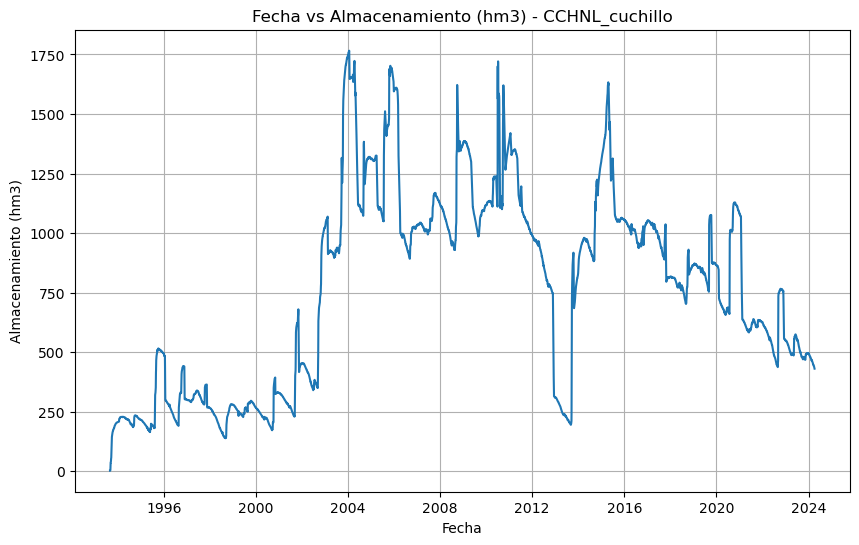

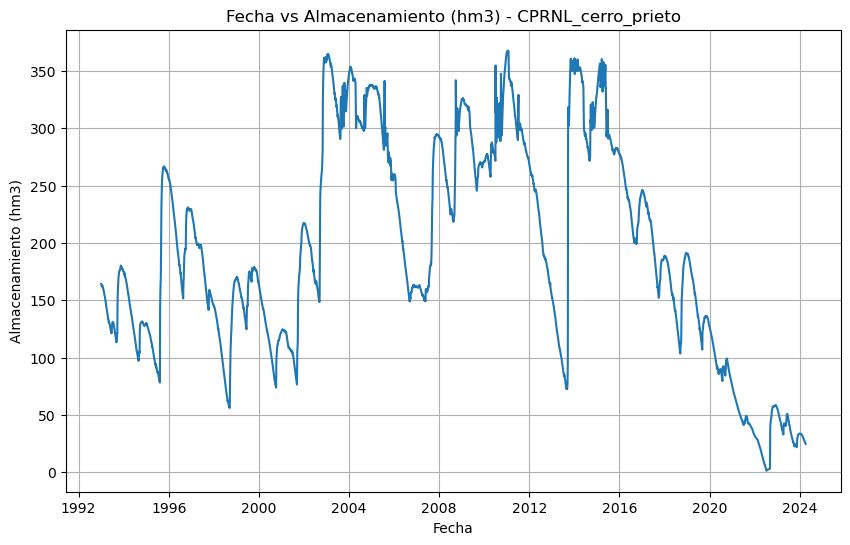

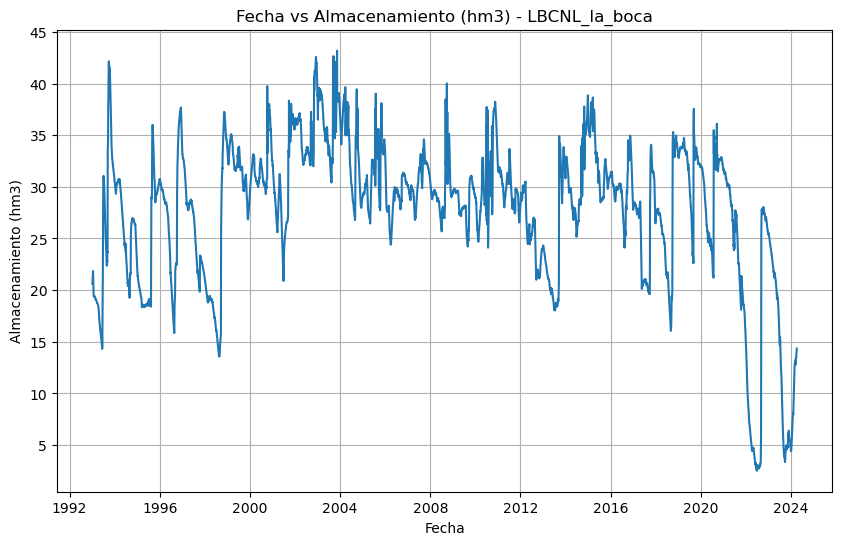

In [29]:
plot_precipitation(dataframes)